In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installing packages, downloading necessary files and features


In [118]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import random
import seaborn as sns
import time
import xgboost
import sklearn
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve
from sklearn.metrics import mean_squared_error, make_scorer, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

In [20]:
#File paths
CPP_sample_path = '/content/drive/MyDrive/TriplEP-CPP/Training sample/'
Models_path = '/content/drive/MyDrive/TriplEP-CPP/Models/'
Matching_path = '/content/drive/MyDrive/TriplEP-CPP/Models/Matching/'

#Reading of descriptor file and selection of vector y
df_SAMPLE = pd.read_csv(CPP_sample_path + 'df_TRAINING_SAMPLE.csv')
df_DESC = df_SAMPLE.copy()
del df_DESC['Sequence']
y = df_DESC['CPP'].values
del df_DESC['CPP']

#Frequently used variables
final_desc = ['InstabilityInd',
              '_ChargeD1025', '_ChargeD1075', '_ChargeD1100',
              '_ChargeD3001', '_ChargeD3100',
              '_NormalizedVDWVD1001', '_NormalizedVDWVD2001',
              '_NormalizedVDWVD2025', '_NormalizedVDWVD2075',
              '_PolarityD1075', '_PolarityD3025',
              '_PolarizabilityD1100',
              '_SecondaryStrD2025', '_SecondaryStrD2075', '_SecondaryStrD2100',
              '_SecondaryStrD3025', '_SecondaryStrD3100',
              '_SolventAccessibilityD3025', '_SolventAccessibilityD3100']
model_name_short = ['KN_model', 'XGB_model', 'RF_model']
model_name_full =  ['K-Nearest Neighbors', 'Gradient Boosting', 'Random Forest']
matching_models_name = ['TriplEP-CPP', 'BChemRF-CPPred', 'C2Pred', 'MLCPP']
palette1 = ['#fcd07e', '#b3c0af', '#87a17e', '#cd9742', '#3f5837', '#cdaf7e']
palette2 = ['#3f5837', '#b3c0af', '#a16d36', '#87a17e', '#cd9742', '#fcd07e']
palette3 = ['#3f5837', '#87a17e', '#b3c0af', '#a16d36', '#cd9742', '#fcd07e']

In [ ]:
#Models ACCURACY
KN_model_accuracy = joblib.load(CPP_sample_path + 'KN_model_accuracy.pkl')
XGB_model_accuracy = joblib.load(CPP_sample_path + 'XGB_model_accuracy.pkl')
RF_model_accuracy = joblib.load(CPP_sample_path + 'RF_model_accuracy.pkl')

#Models PRECISION
KN_model_precision = joblib.load(CPP_sample_path + 'KN_model_precision.pkl')
XGB_model_precision = joblib.load(CPP_sample_path + 'XGB_model_precision.pkl')
RF_model_precision = joblib.load(CPP_sample_path + 'RF_model_precision.pkl')

#Selected models
XGB_model_final = joblib.load(CPP_sample_path + 'XGB_model_final.pkl')
KN_model_final = joblib.load(CPP_sample_path + 'KN_model_final.pkl')
RF_model_final = joblib.load(CPP_sample_path + 'RF_model_final.pkl')

In [147]:
#Create a metrics dictionary
def create_score_dict(dict_name, names):
    dict_name['Method'] = names
    dict_name['Accuracy'] = list()
    dict_name['F1'] = list()
    dict_name['Precision'] = list()
    dict_name['Recall'] = list()
    dict_name['ROC AUC'] = list()
    return dict_name

#Key metrics
def calculate_metrics(model, x, y):
    pred = model.predict(x)
    a = accuracy_score(y, pred)
    f = f1_score(y, pred)
    p = precision_score(y, pred)
    r = recall_score(y, pred)
    #pred = model.predict_proba(x)[:, 1]
    ra = roc_auc_score(y, pred)
    return a, f, p, r, ra

#Putting metrics into a dictionary
def write_in_score_dict(dict_name, a, f, p, r, ra):
    dict_name['Accuracy'].append('%.2f%%' % (np.array(a).mean() * 100.0))
    dict_name['F1'].append('%.2f%%' % (np.array(f).mean() * 100.0))
    dict_name['Precision'].append('%.2f%%' % (np.array(p).mean() * 100.0))
    dict_name['Recall'].append('%.2f%%' % (np.array(r).mean() * 100.0))
    dict_name['ROC AUC'].append('%.2f%%' % (np.array(ra).mean() * 100.0))
    return dict_name

#Quick start
def quick_count(model, x, y, dict_name):
    accuracy, f1, precision, recall, roc_auc = calculate_metrics(model, x, y)
    dict_name = write_in_score_dict(dict_name, accuracy, f1, precision, recall, roc_auc)
    return dict_name

#Cross-validation
def cross_validation(k, x_train, y_train, model, dict_name):
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    ra, a, f, p, r = [], [], [], [], []
    for train_index, test_index in cv.split(x_train, y_train):
        X_train_, y_train_ = X_train[train_index], y_train[train_index]
        X_val, y_val = X_train[test_index], y_train[test_index]
        model.fit(X_train_, y_train_)
        pred = model.predict(X_val)
        a.append(accuracy_score(y_val, pred))
        f.append(f1_score(y_val, pred))
        p.append(precision_score(y_val, pred))
        r.append(recall_score(y_val, pred))
        pred = model.predict_proba(X_val)[:, 1]
        ra.append(roc_auc_score(y_val, pred))
    write_in_score_dict(dict_name, a, f, p, r, ra)
    return dict_name

#Additional parameters for model evaluation
def summary_parameters(models, names, X, y):
    summary_score = dict()
    summary_score = create_score_dict(summary_score, names)
    summary_score['ROC-curve'] = []
    summary_score['Predicted'] = []
    for model in models:
        summary_score = quick_count(model, X, y, summary_score)
        y_pred = model.predict_proba(X)[:,1]
        summary_score['ROC-curve'].append(roc_auc_score(y, y_pred))
        summary_score['Predicted'].append(y_pred)
    return summary_score

#Image formatting
large = 22; med = 16; small = 12
params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}
plt.rcParams.update(params)
plt.style.use('seaborn-whitegrid')
sns.set_style('white')
%matplotlib inline

<ipython-input-147-466fb9438f18>:79: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# Algorithm creation

In [23]:
#Normalisation
scaler = StandardScaler()
df_FINAL = df_DESC[final_desc].copy()
df_FINAL = scaler.fit_transform(df_FINAL)

#Splitting the sample
X_train, X_test, y_train, y_test = train_test_split(df_FINAL, y,
                                                    train_size=0.85,
                                                    shuffle = True,
                                                    random_state = 40)

## Optimal hyperparameter selection

In [ ]:
#ACCURACY
#KN_model_accuracy = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=18, weights='distance')
#XGB_model_accuracy = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.0567, max_depth=8, n_estimators=250)
#RF_model_accuracy = RandomForestClassifier(criterion='entropy', max_features= 'log2', n_estimators=195)

#PRECISION
#KN_model_precision = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=20, weights='uniform')
#XGB_model_precision = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.0567, max_depth=8, n_estimators=250)
#RF_model_precision = RandomForestClassifier(criterion='gini', max_features= 'log2', n_estimators=20)

### K-nearest neighbours

In [76]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
KN_grid_search = GridSearchCV(KNeighborsClassifier(n_jobs = -1),
                               [{'n_neighbors': np.array(np.linspace(16, 22, 6), dtype='int'),
                                 'metric': ['minkowski', 'manhattan', 'euclidean', 'chebyshev'],
                                 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                                 'weights': ['uniform', 'distance']}],
                              refit='Accuracy',
                              #refit='Precision',
                              return_train_score=True,
                              cv=10,
                              scoring=scoring,
                              error_score='raise',
                              verbose=10)

In [ ]:
#KN_grid_search.fit(df_FINAL, y)

In [79]:
#ACCURACY
print(KN_grid_search.best_params_)
print(KN_grid_search.best_score_)
print(KN_grid_search.best_estimator_)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 18, 'weights': 'distance'}
0.8403361344537815
KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=18,
                     weights='distance')


In [105]:
KN_model_accuracy = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=18, weights='distance')
KN_model_accuracy.fit(X_train, y_train)
KN_name_accuracy = Models_path + 'KN_model_accuracy.pkl'
joblib.dump(KN_model_accuracy, KN_name_accuracy)
KN_name_final = Models_path + 'KN_model.pkl'
joblib.dump(KN_model_accuracy, KN_name_final)
KN_model = KN_model_accuracy

In [53]:
#PRECISION
print(KN_grid_search.best_params_)
print(KN_grid_search.best_score_)
print(KN_grid_search.best_estimator_)

{'algorithm': 'auto', 'metric': 'manhattan', 'n_neighbors': 20, 'weights': 'uniform'}
0.9054178069137521
KNeighborsClassifier(metric='manhattan', n_jobs=-1, n_neighbors=20)


In [58]:
KN_model_precision = KNeighborsClassifier(algorithm='auto', metric='manhattan', n_neighbors=20, weights='uniform')
KN_model_precision.fit(X_train, y_train)
KN_name_precision = Models_path + 'KN_model_precision.pkl'
joblib.dump(KN_model_precision, KN_name_precision)

['/content/drive/MyDrive/TriplEP-CPP/Models/KN_model_precision.pkl']

### Gradient boosting

In [71]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
GBR_grid_search = GridSearchCV(xgboost.XGBClassifier(n_jobs=-1),
                               [{'learning_rate': np.array(np.linspace(0.01, 0.15, 4), dtype='float'),
                                 'n_estimators': np.array(np.linspace(50, 300, 6), dtype='int'),
                                 'max_depth': np.array(np.linspace(2, 10, 5), dtype='int'),
                                 'booster': ['gbtree', 'gblinear', 'dart']}],
                              scoring=scoring,
                              refit='Accuracy',
                              #refit='Precision',
                              return_train_score=True,
                              cv=10,
                              error_score='raise',
                              verbose=10)

In [ ]:
#GBR_grid_search.fit(df_FINAL, y)

In [73]:
#ACCURACY
print(GBR_grid_search.best_params_)
print(GBR_grid_search.best_score_)
print(GBR_grid_search.best_estimator_)

{'booster': 'gbtree', 'learning_rate': 0.056666666666666664, 'max_depth': 8, 'n_estimators': 250}
0.8453781512605042
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.056666666666666664,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


In [95]:
XGB_model_accuracy = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.0567, max_depth=8, n_estimators=250)
XGB_model_accuracy.fit(X_train, y_train)
XGB_name_accuracy = Models_path + 'XGB_model_accuracy.pkl'
joblib.dump(XGB_model_accuracy, XGB_name_accuracy)

['/content/drive/MyDrive/TriplEP-CPP/Models/XGB_model_accuracy.pkl']

In [84]:
#PRECISION
print(GBR_grid_search.best_params_)
print(GBR_grid_search.best_score_)
print(GBR_grid_search.best_estimator_)

{'booster': 'gbtree', 'learning_rate': 0.056666666666666664, 'max_depth': 8, 'n_estimators': 250}
0.8896665762635955
XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.056666666666666664,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=8, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=250, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)


In [111]:
XGB_model_precision = xgboost.XGBClassifier(booster='gbtree', learning_rate=0.0567, max_depth=8, n_estimators=250)
XGB_model_precision.fit(X_train, y_train)
XGB_name_precision = Models_path + 'XGB_model_precision.pkl'
joblib.dump(XGB_model_precision, XGB_name_precision)
XGB_name_final = Models_path + 'XGB_model.pkl'
joblib.dump(XGB_model_precision, XGB_name_final)
XGB_model = XGB_model_precision

### Random forest

In [97]:
scoring = {'Accuracy': make_scorer(accuracy_score), 'Precision': make_scorer(precision_score)}
RF_grid_search = GridSearchCV(RandomForestClassifier(n_jobs=-1),
                               [{'n_estimators': np.array(np.linspace(20, 320, 13), dtype='int'),
                                 'max_features': ['auto', 'sqrt', 'log2'],
                                 'criterion': ['gini', 'entropy']}],
                              scoring=scoring,
                              #refit='Accuracy',
                              refit='Precision',
                              return_train_score=True,
                              cv=10,
                              error_score='raise',
                              verbose=10)

In [ ]:
RF_grid_search.fit(df_FINAL, y)

In [93]:
#ACCURACY
print(RF_grid_search.best_params_)
print(RF_grid_search.best_score_)
print(RF_grid_search.best_estimator_)

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 195}
0.8428571428571429
RandomForestClassifier(criterion='entropy', max_features='log2',
                       n_estimators=195, n_jobs=-1)


In [94]:
RF_model_accuracy = RandomForestClassifier(criterion='entropy', max_features= 'log2', n_estimators=195)
RF_model_accuracy.fit(X_train, y_train)
RF_name_accuracy = Models_path + 'RF_model_accuracy.pkl'
joblib.dump(RF_model_accuracy, RF_name_accuracy)

['/content/drive/MyDrive/TriplEP-CPP/Training sample/RF_model_accuracy.pkl']

In [100]:
#PRECISION
print(RF_grid_search.best_params_)
print(RF_grid_search.best_score_)
print(RF_grid_search.best_estimator_)

{'criterion': 'gini', 'max_features': 'log2', 'n_estimators': 20}
0.8886757313930916
RandomForestClassifier(max_features='log2', n_estimators=20, n_jobs=-1)


In [110]:
RF_model_precision = RandomForestClassifier(criterion='gini', max_features= 'log2', n_estimators=20)
RF_model_precision.fit(X_train, y_train)
RF_name_precision = Models_path + 'RF_model_precision.pkl'
joblib.dump(RF_model_precision, RF_name_precision)
RF_name_final = Models_path + 'RF_model.pkl'
joblib.dump(RF_model_precision, RF_name_final)
RF_model = RF_model_precision

## Predictive ability assessment

In [102]:
models_accuracy = [KN_model_accuracy, XGB_model_accuracy, RF_model_accuracy]
models_precision = [KN_model_precision, XGB_model_precision, RF_model_precision]

In [103]:
final_score_accuracy = pd.DataFrame(summary_parameters(models_accuracy, model_name_full, X_test, y_test))
final_score_accuracy

,Method,Accuracy,F1,Precision,Recall,ROC AUC,ROC-curve,Predicted
0,K-Nearest Neighbors,87.96%,87.01%,87.80%,86.23%,93.49%,0.934904,"[0.0, 0.062013382568073386, 0.8932378911885775..."
1,Gradient Boosting,88.24%,87.57%,86.55%,88.62%,94.25%,0.942452,"[0.006333524, 0.020117834, 0.99833786, 0.01428..."
2,Random Forest,85.99%,85.21%,84.21%,86.23%,94.22%,0.942153,"[0.041025641025641026, 0.24102564102564103, 0...."


In [104]:
final_score_precision = pd.DataFrame(summary_parameters(models_precision, model_name_full, X_test, y_test))
final_score_precision

,Method,Accuracy,F1,Precision,Recall,ROC AUC,ROC-curve,Predicted
0,K-Nearest Neighbors,86.55%,85.09%,88.39%,82.04%,92.66%,0.926615,"[0.0, 0.05, 0.9, 0.05, 0.15, 1.0, 0.0, 0.3, 0...."
1,Gradient Boosting,88.24%,87.57%,86.55%,88.62%,94.25%,0.942452,"[0.006333524, 0.020117834, 0.99833786, 0.01428..."
2,Random Forest,86.83%,85.89%,86.14%,85.63%,93.53%,0.935345,"[0.15, 0.3, 0.9, 0.15, 0.05, 0.95, 0.0, 0.6, 0..."


## ROC curve quality check

### For accuracy trained models

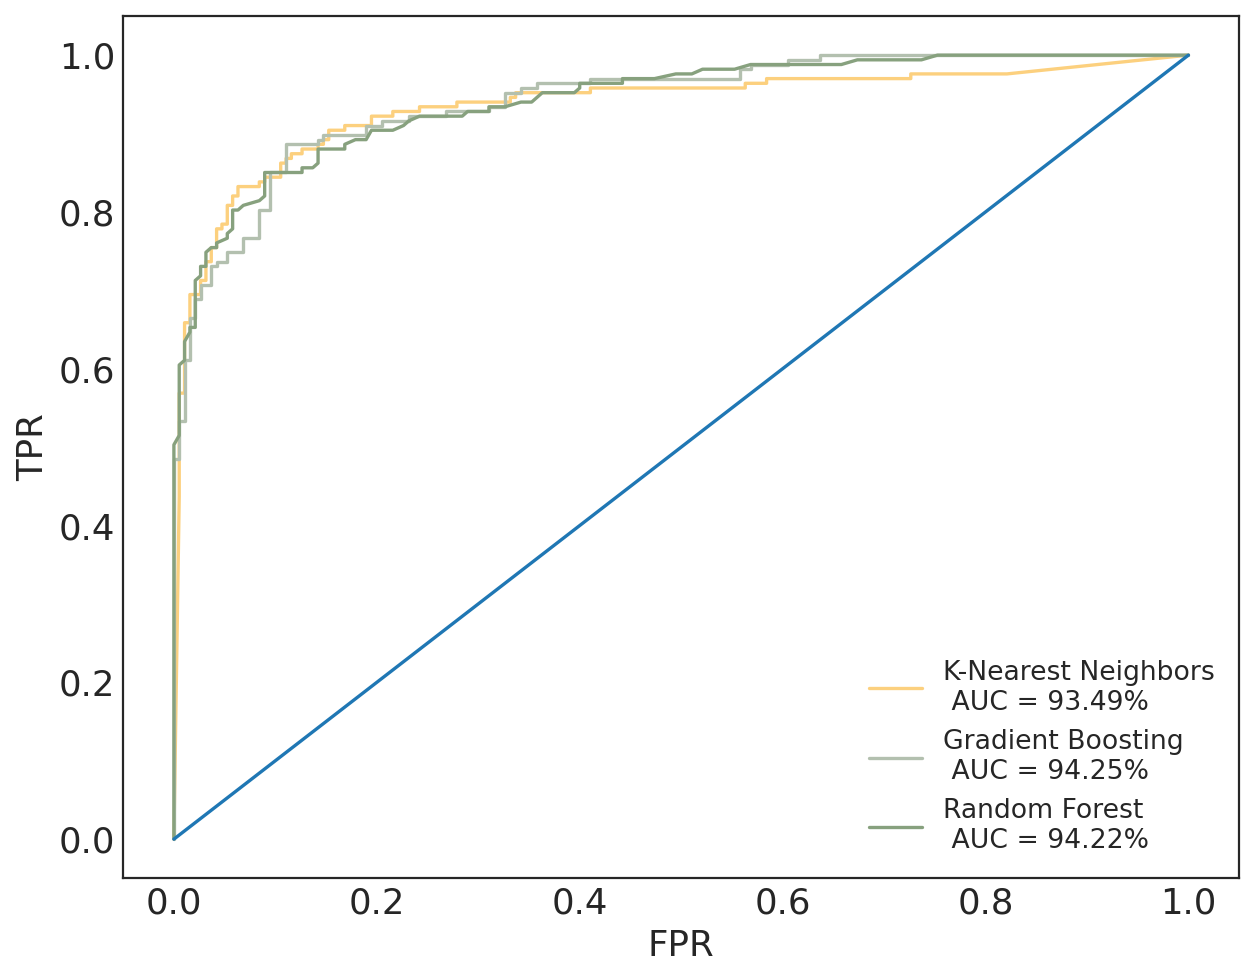

In [112]:
plt.figure(figsize=(9,7), dpi= 160)
options = zip(model_name_full, final_score_accuracy['Predicted'], final_score_accuracy['ROC-curve'], palette1)
for name, predict, rocauc, color in options:
    name = name + '\n AUC = %.2f%%'%(rocauc*100)
    plt.plot(*roc_curve(y_test, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

### For precision trained models

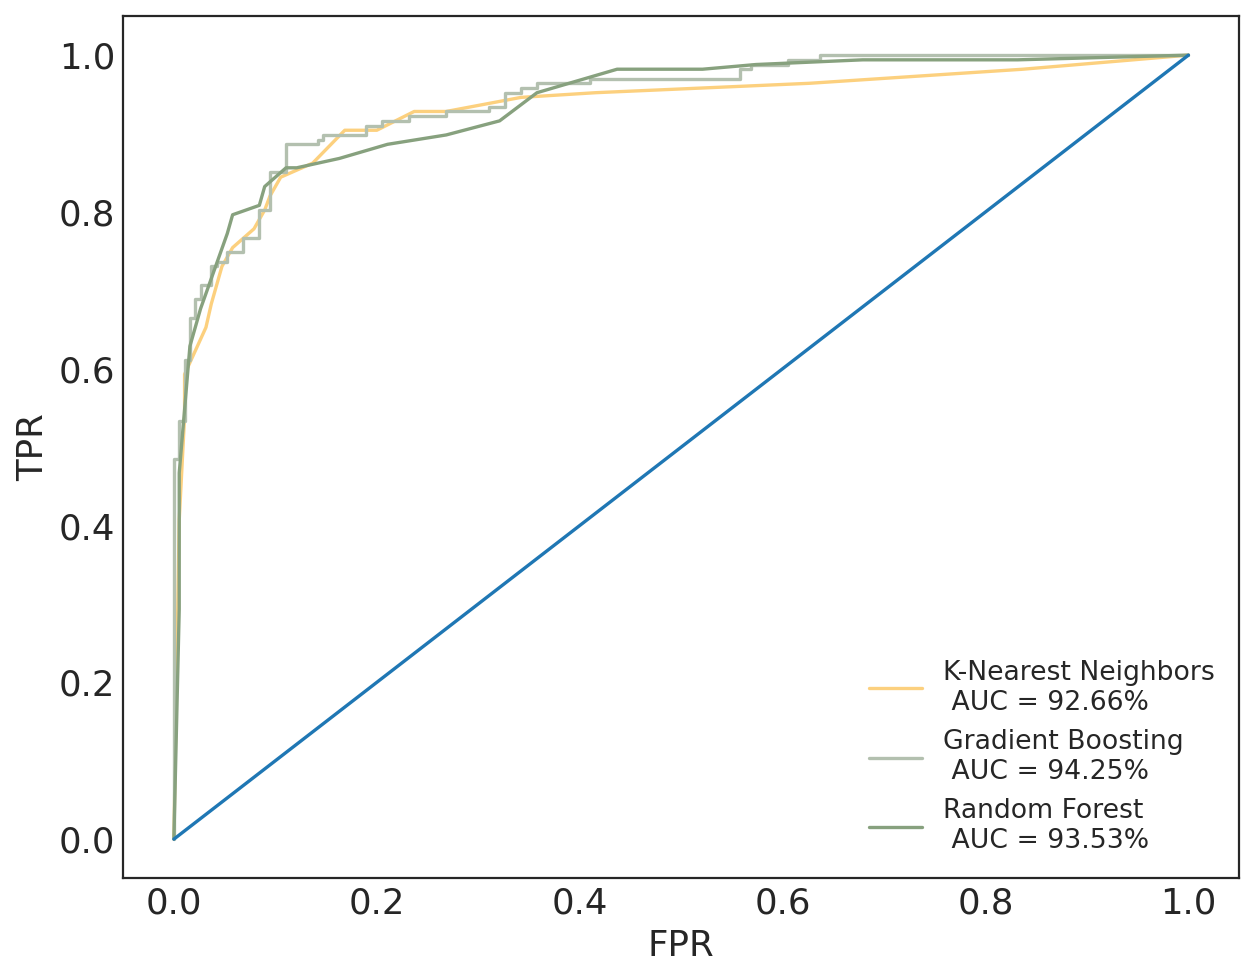

In [113]:
plt.figure(figsize=(9,7), dpi= 160)
options = zip(model_name_full, final_score_precision['Predicted'], final_score_precision['ROC-curve'], palette1)
for name, predict, rocauc, color in options:
    name = name + '\n AUC = %.2f%%'%(rocauc*100)
    plt.plot(*roc_curve(y_test, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Retraining test

In [114]:
def roc_auc_curve(model, x, y, y_pred, auc_score):
    y_test_pred = model.predict_proba(x)[:, 1]
    test_auc = roc_auc_score(y, y_test_pred)
    y_pred.append(y_test_pred)
    auc_score.append(test_auc)
    return y_pred, auc_score

In [116]:
final_models = [KN_model, XGB_model, RF_model]
final_models_name = ['K-Nearest Neighbours \nTeaching sample', 'K-Nearest Neighbours \nTest sample',
                     'Gradient Boosting \nTest Sampling', 'Gradient Boosting \nTest Sampling',
                     'Random Forest \nTest Sampling', 'Random Forest \nTest Sampling']
y_test_train = [y_train, y_test, y_train, y_test, y_train, y_test]
y_predicted = list()
auc = list()
for model in final_models:
    y_predicted, auc = roc_auc_curve(model, X_train, y_train, y_predicted, auc)
    y_predicted, auc = roc_auc_curve(model, X_test, y_test, y_predicted, auc)

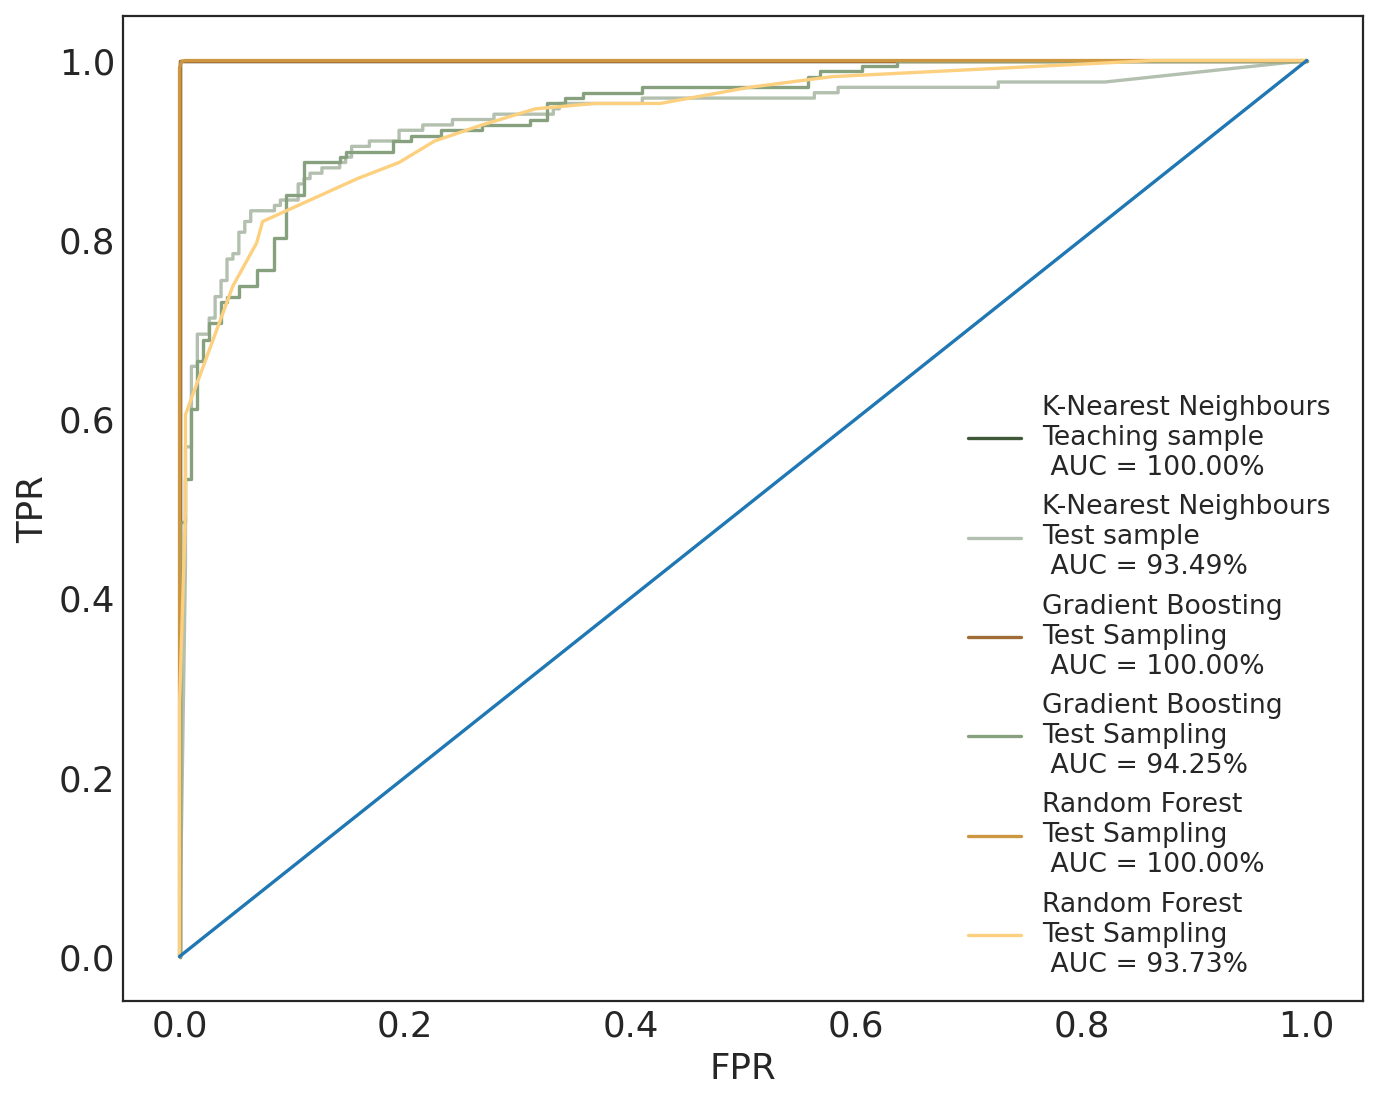

In [117]:
plt.figure(figsize=(10,8), dpi= 160)
options = zip(final_models_name, y_predicted, auc, palette2, y_test_train)
for name, predict, rocauc, color, y_tt in options:
    name = name + '\n AUC = %.2f%%'%(rocauc*100)
    plt.plot(*roc_curve(y_tt, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

## Trained model stacking

In [128]:
estimators = [('KNN', KN_model), ('XGB', XGB_model), ('RFM', RF_model)]
f__estimator = [DecisionTreeClassifier(), SVC(), KNeighborsClassifier(),
                LogisticRegression(), RandomForestClassifier(), xgboost.XGBClassifier()]
#SC_grid_search = StackingClassifier(estimators=estimators, final_estimator=SVC())

In [135]:
SC_grid_search = GridSearchCV(StackingClassifier(estimators=estimators, n_jobs=-1),
                               [{'final_estimator': f__estimator}],
                              scoring=scoring,
                              #refit='Accuracy',
                              refit='Precision',
                              return_train_score=True,
                              cv=10,
                              error_score='raise',
                              verbose=10)

In [ ]:
SC_grid_search.fit(X_train, y_train)

In [132]:
#ACCURACY
print(SC_grid_search.best_params_)
print(SC_grid_search.best_score_)
print(SC_grid_search.best_estimator_)

{'final_estimator': SVC()}
0.8873018582646444
StackingClassifier(estimators=[('KNN',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=18,
                                                     weights='distance')),
                               ('XGB',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                       

In [134]:
TriplEP_accuracy = StackingClassifier(estimators=estimators, final_estimator=SVC())
TriplEP_accuracy.fit(X_train, y_train)
TriplEP_name_accuracy = Models_path + 'TriplEP_accuracy.pkl'
joblib.dump(TriplEP_accuracy, TriplEP_name_accuracy)

['/content/drive/MyDrive/TriplEP-CPP/Models/TriplEP_accuracy.pkl']

In [138]:
#PRECISION
print(SC_grid_search.best_params_)
print(SC_grid_search.best_score_)
print(SC_grid_search.best_estimator_)

{'final_estimator': SVC()}
0.9041864435233394
StackingClassifier(estimators=[('KNN',
                                KNeighborsClassifier(metric='manhattan',
                                                     n_neighbors=18,
                                                     weights='distance')),
                               ('XGB',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                       

In [199]:
TriplEP = StackingClassifier(estimators=estimators, final_estimator=SVC())
TriplEP.fit(X_train, y_train)
TriplEP_name = Models_path + 'TriplEP_CPP.pkl'
#joblib.dump(TriplEP, TriplEP_name)

# Comparison with existing models

In [ ]:
#From the full list of peptides we filter out those outside the 5 - 30 aa range.
#Randomise a sample of 1000 peptides
df_SAMPLE = pd.read_csv(Total_sample_path + 'df_SAMPLE.csv')
CPP = list()
nCPP = list()
for index, row in df_SAMPLE.iterrows():
    if 5 <= len(row.Sequence) <= 35:
        if row.CPP:
            CPP.append(row.Sequence)
        else:
            nCPP.append(row.Sequence)
CPP_500 = random.sample(CPP, 500)
true = [True] * len(CPP_500)
nCPP_500 = random.sample(nCPP, 500)
false = [False] * len(nCPP_500)
sequence = CPP_500 + nCPP_500
cpp_flag = true + false
df_THOUSAND = pd.DataFrame({'CPP': cpp_flag, 'Sequence': sequence})
#df_THOUSAND.to_csv(Matching_path + 'df_THOUSAND.csv', index=False)
#with open(Matching_path + 'df_THOUSAND.fasta', 'w') as file:
#    for seq in sequence:
#      file.write('>' + seq + '\n')
#      file.write(seq + '\n')

In [172]:
df_THOUSAND = pd.read_csv(Matching_path + 'df_THOUSAND.csv')
sequence = list(df_THOUSAND.Sequence)
df_MATCHING = df_SAMPLE.copy()
df_MATCHING = df_MATCHING[df_MATCHING.Sequence.isin(sequence)]
sequence = list(df_MATCHING.Sequence)
y_matching = df_MATCHING.CPP
df_MATCHING = df_MATCHING[final_desc].copy()
scaler = StandardScaler()
df_MATCHING = scaler.fit_transform(df_MATCHING)

In [148]:
matching = dict()
matching = create_score_dict(matching, matching_models_name)
matching = quick_count(TriplEP, df_MATCHING, y_matching, matching)

## BChemRF-CPPred

In [175]:
CPPred = pd.read_csv(Matching_path + 'BChemRF-CPPred.csv')
pred_CPPred = list()
pred_CPPred_probability = list()
for index, row in CPPred.iterrows():
    seq = row['Classification']
    if seq == 'CPP':
        pred_CPPred.append(True)
        prob = float(row['Probability'][:-1])*0.01
        pred_CPPred_probability.append(prob)
    else:
        pred_CPPred.append(False)
        prob = 1 - float(row['Probability'][:-1])*0.01
        pred_CPPred_probability.append(prob)

In [176]:
accuracy = accuracy_score(y_matching, pred_CPPred)
f1 = f1_score(y_matching, pred_CPPred)
precision = precision_score(y_matching, pred_CPPred)
recall = recall_score(y_matching, pred_CPPred)
roc_auc = roc_auc_score(y_matching, pred_CPPred_probability)
matching = write_in_score_dict(matching, accuracy, f1, precision, recall, roc_auc)

## C2Pred

In [198]:
C2Pred = pd.read_excel(Matching_path + 'C2Pred.xlsx')
pred_C2Pred = list()
pred_C2Pred_probability = list()
for index, row in C2Pred.iterrows():
    seq = row[C2Pred.columns[0]].strip().split()[0]
    prob = row[C2Pred.columns[0]].strip().split()[1]
    if seq == 'CPP':
        pred_C2Pred.append(True)
        pred_C2Pred_probability.append(float(prob))
    else:
        pred_C2Pred.append(False)
        pred_C2Pred_probability.append(float(prob))

In [190]:
accuracy = accuracy_score(y_matching, pred_C2Pred)
f1 = f1_score(y_matching, pred_C2Pred)
precision = precision_score(y_matching, pred_C2Pred)
recall = recall_score(y_matching, pred_C2Pred)
roc_auc = roc_auc_score(y_matching, pred_C2Pred_probability)
matching = write_in_score_dict(matching, accuracy, f1, precision, recall, roc_auc)

## MLCPP

In [192]:
MLCPP = pd.read_excel(Matching_path + 'MLCPP.xlsx')
pred_MLCPP = list()
pred_MLCPP_probability = list()
for index, row in MLCPP.iterrows():
    seq = row['Cell-penetrating or not'].strip().split()[0]
    prob = float(row['Probability score'])
    if seq == 'CPP':
        pred_MLCPP.append(True)
        pred_MLCPP_probability.append(prob)
    else:
        pred_MLCPP.append(False)
        pred_MLCPP_probability.append(prob)

In [193]:
accuracy = accuracy_score(y_matching, pred_MLCPP)
f1 = f1_score(y_matching, pred_MLCPP)
precision = precision_score(y_matching, pred_MLCPP)
recall = recall_score(y_matching, pred_MLCPP)
roc_auc = roc_auc_score(y_matching, pred_MLCPP_probability)
matching = write_in_score_dict(matching, accuracy, f1, precision, recall, roc_auc)

## Результаты

In [194]:
pd.DataFrame(matching)

,Method,Accuracy,F1,Precision,Recall,ROC AUC
0,TriplEP-CPP,98.09%,98.08%,97.59%,98.58%,98.09%
1,BChemRF-CPPred,86.20%,84.83%,93.41%,77.69%,93.08%
2,C2Pred,83.28%,83.82%,80.68%,87.22%,90.35%
3,MLCPP,92.25%,92.44%,89.54%,95.54%,97.79%


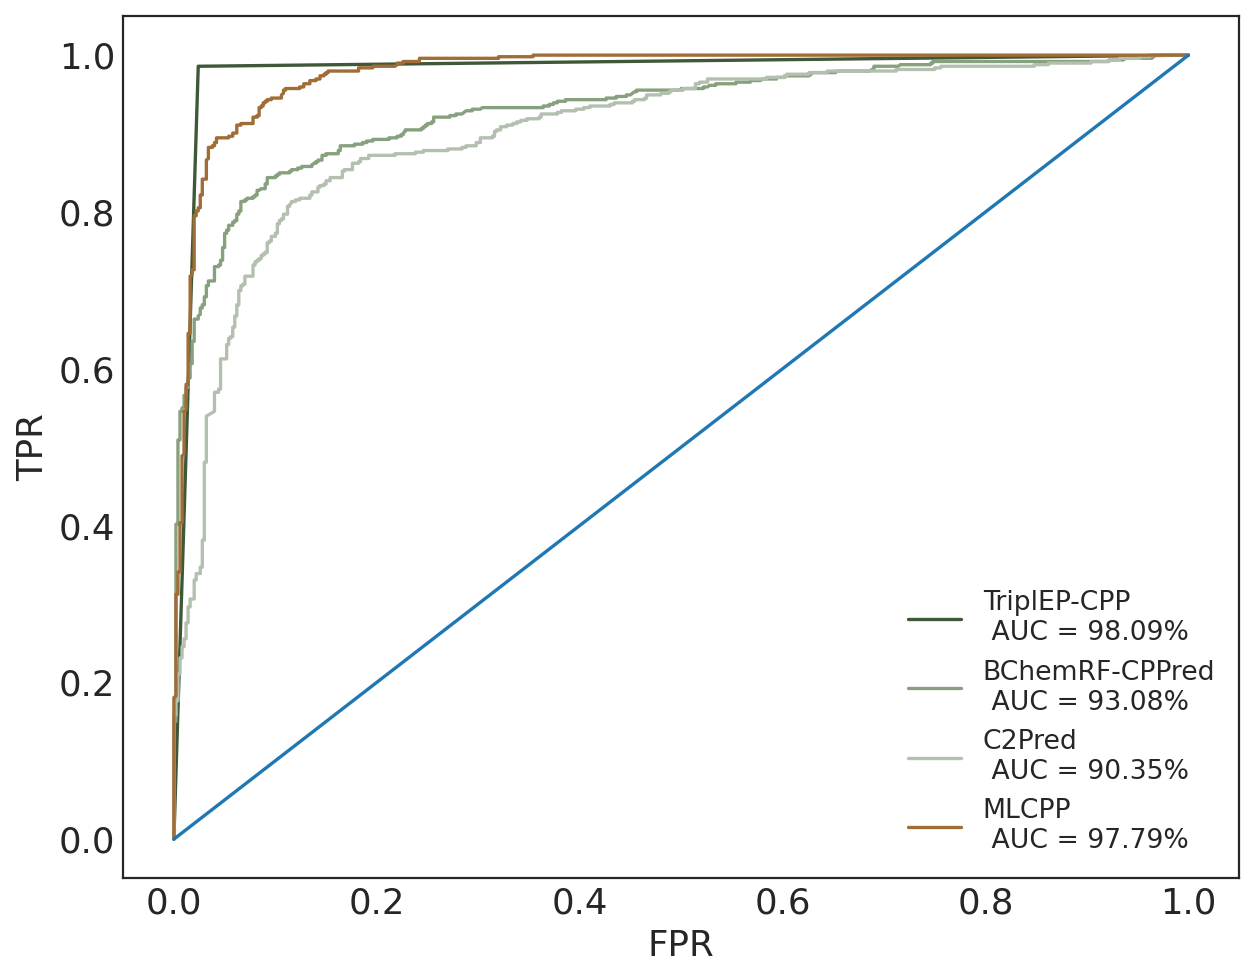

In [197]:
predicted = [TriplEP.predict(df_MATCHING),
             pred_CPPred_probability, pred_C2Pred_probability, pred_MLCPP_probability]
plt.figure(figsize=(9,7), dpi= 160)
options = zip(matching_models_name, pd.DataFrame(matching)['ROC AUC'], predicted, palette3)
for name, rocauc, predict, color in options:
    name = name + '\n AUC = ' + rocauc
    plt.plot(*roc_curve(y_matching, predict)[:2], label=name, color = color)
legend_box = plt.legend(fontsize=12, framealpha=1).get_frame()
legend_box.set_facecolor('white')
legend_box.set_edgecolor('black')
#plt.title('Receiver operating characteristic curve', fontsize=20)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()